# Project: CliniScan - Lung Abnormality Detection
# Dataset: VinDr-CXR (Chest X-rays)
# Model: YOLOv8
# Created by: Prarthana


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Nov 29 04:29:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print("CUDA available for PyTorch:", torch.cuda.is_available())

CUDA available for PyTorch: True


In [ ]:
import os

BASE = "/content/drive/MyDrive/CliniScan"
folders = [
    "1_Dataset",
    "2_EDA",
    "3_Preprocessing",
    "4_Augmentation",
    "5_Model",
    "6_Evaluation",
    "7_Results_and_Report"
]
for f in folders:
    os.makedirs(os.path.join(BASE, f), exist_ok=True)
print("Project folders created under:", BASE)

Project folders created under: /content/drive/MyDrive/CliniScan


In [ ]:
!ls /content/drive/MyDrive/CliniScan

1_Dataset  3_Preprocessing  5_Model	  7_Results_and_Report
2_EDA	   4_Augmentation   6_Evaluation


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"basketball997789","key":"3803d1515cb4cef1a9a764927dd28472"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/CliniScan/1_Dataset"
!kaggle datasets download -d lmtuan/vinbigdatachestxrayabnormalities512x512jp2 \
  --path /content/drive/MyDrive/CliniScan/1_Dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/lmtuan/vinbigdatachestxrayabnormalities512x512jp2
License(s): unknown
 99% 1.73G/1.75G [00:10<00:00, 207MB/s]
100% 1.75G/1.75G [00:11<00:00, 168MB/s]


In [ ]:
!ls /content/drive/MyDrive/CliniScan/1_Dataset

vinbigdata-chest-xray-abnormalities-detection-512x512-jp2


In [ ]:
!ls /content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2

sample_submission.csv  test  test.csv  train  train.csv  train_meta.csv


# EDA

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random

BASE = "/content/drive/MyDrive/CliniScan"
DATA_DIR = os.path.join(
    BASE,
    "1_Dataset",
    "vinbigdata-chest-xray-abnormalities-detection-512x512-jp2"
)
CSV_PATH = os.path.join(DATA_DIR, "train.csv")
IMAGE_DIR = os.path.join(DATA_DIR, "train")

EDA_DIR = os.path.join(BASE, "2_EDA")
os.makedirs(EDA_DIR, exist_ok=True)

print("CSV_PATH:", CSV_PATH)
print("IMAGE_DIR:", IMAGE_DIR)
print("EDA_DIR:", EDA_DIR)

CSV_PATH: /content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train.csv
IMAGE_DIR: /content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train
EDA_DIR: /content/drive/MyDrive/CliniScan/2_EDA


In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,170.09,301.37,406.89,401.32,2080,2336
3,3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,280.89,132.09,358.00,181.16,2304,2880
4,4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [ ]:
print("Total bounding-box rows in CSV:", len(df))
print("Total unique images:", df["image_id"].nunique())
print("Number of classes:", df["class_name"].nunique())
print("\nClass names:")
print(df["class_name"].unique())

Total bounding-box rows in CSV: 67914
Total unique images: 15000
Number of classes: 15

Class names:
['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening'
 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis'
 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification'
 'Consolidation' 'Pneumothorax']


Class counts:

class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64


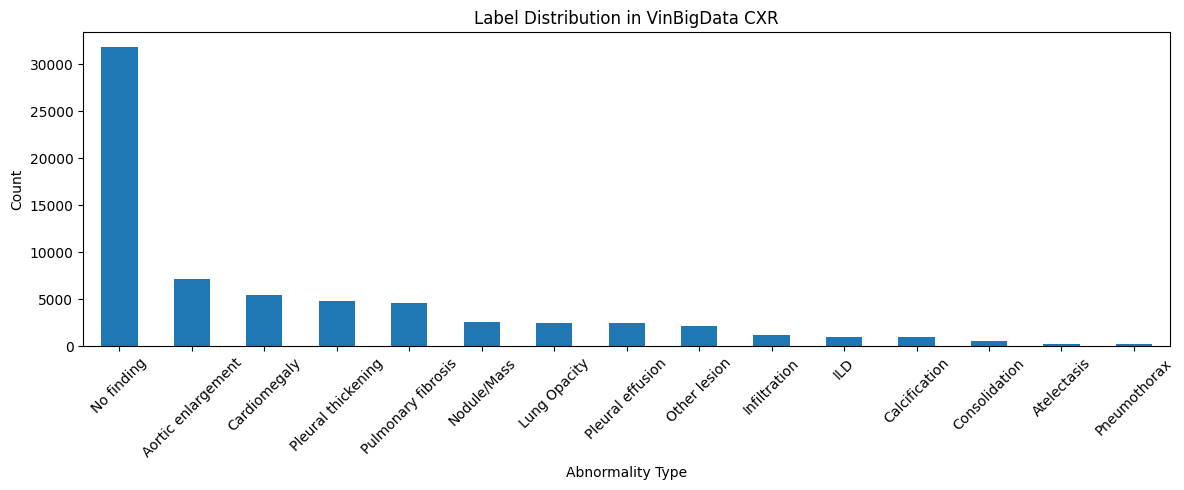

Most common class: No finding
Least common class: Pneumothorax
Imbalance ratio (max/min): 140.79


In [ ]:
class_counts = df["class_name"].value_counts()
print("Class counts:\n")
print(class_counts)
plt.figure(figsize=(12, 5))
class_counts.plot(kind="bar")
plt.title("Label Distribution in VinBigData CXR")
plt.xlabel("Abnormality Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "class_distribution.png"))
plt.show()

print("Most common class:", class_counts.idxmax())
print("Least common class:", class_counts.idxmin())
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio (max/min):", round(imbalance_ratio, 2))

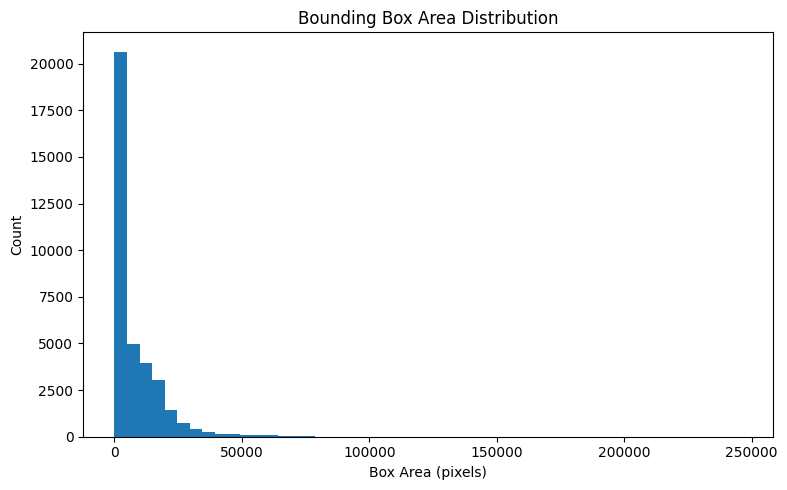

In [ ]:
df["box_width"] = df["x_max"] - df["x_min"]
df["box_height"] = df["y_max"] - df["y_min"]
df["box_area"] = df["box_width"] * df["box_height"]
df[["box_width", "box_height", "box_area"]].describe()
plt.figure(figsize=(8, 5))
plt.hist(df["box_area"], bins=50)
plt.title("Bounding Box Area Distribution")
plt.xlabel("Box Area (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "box_area_distribution.png"))
plt.show()


size_type
Large     32526
Medium    22404
Small     12984
Name: count, dtype: int64


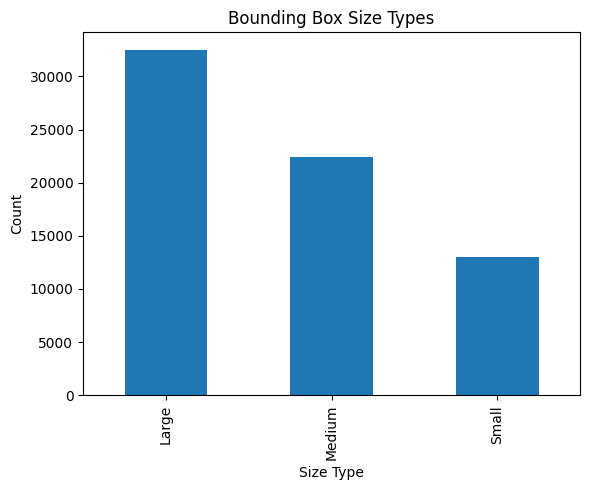

In [ ]:
def size_category(area):
    if area < 50 * 50:
        return "Small"
    elif area < 200 * 200:
        return "Medium"
    else:
        return "Large"

df["size_type"] = df["box_area"].apply(size_category)

print(df["size_type"].value_counts())
plt.figure(figsize=(6, 5))
df["size_type"].value_counts().plot(kind="bar")
plt.title("Bounding Box Size Types")
plt.xlabel("Size Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "box_size_categories.png"))
plt.show()


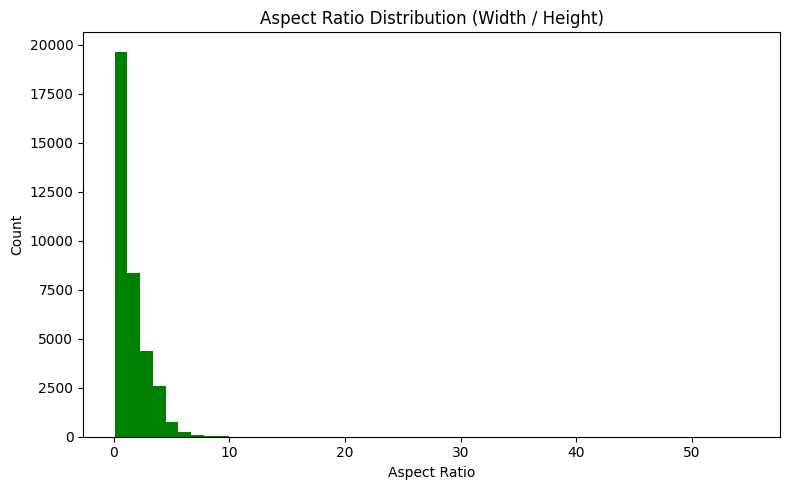

In [ ]:
df["aspect_ratio"] = df["box_width"] / df["box_height"]
df["aspect_ratio"].describe()
plt.figure(figsize=(8, 5))
plt.hist(df["aspect_ratio"], bins=50, color="green")
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "aspect_ratio_distribution.png"))
plt.show()

Random image file: e29fcb9b89f4ccf3e2caeb609b99fb5f.jp2
Image shape: (512, 512)


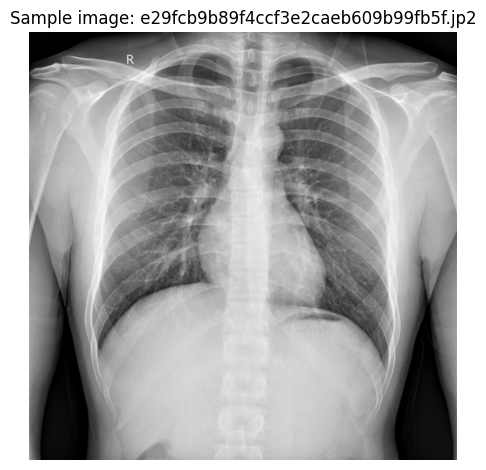

In [ ]:
img_name = random.choice(os.listdir(IMAGE_DIR))
img_path = os.path.join(IMAGE_DIR, img_name)
print("Random image file:", img_name)
img = Image.open(img_path)
img_array = np.array(img)

print("Image shape:", img_array.shape)
plt.imshow(img_array, cmap="gray")
plt.title(f"Sample image: {img_name}")
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, "sample_image.png"))
plt.show()


In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Rows in TRAIN CSV:", len(train_df))
print("Rows in TEST CSV:", len(test_df))

Rows in TRAIN CSV: 67914
Rows in TEST CSV: 3000


# Preprocessing

In [ ]:
import os

BASE = "/content/drive/MyDrive/CliniScan/3_Preprocessing"

folders = [
    "train_jpg",
    "test_jpg",
    "images/train",
    "images/val",
    "images/test"
]

for f in folders:
    os.makedirs(os.path.join(BASE, f), exist_ok=True)

print("Subfolders created inside Preprocessing")


Subfolders created inside Preprocessing


In [ ]:
from PIL import Image
import os
from tqdm import tqdm

OLD_TRAIN = "/content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train"
NEW_TRAIN = "/content/drive/MyDrive/CliniScan/3_Preprocessing/train_jpg"

os.makedirs(NEW_TRAIN, exist_ok=True)

train_files = [f for f in os.listdir(OLD_TRAIN) if f.endswith(".jp2")]

for f in tqdm(train_files, desc="Converting TRAIN"):
    new_name = f.replace(".jp2", ".jpg")
    dst = os.path.join(NEW_TRAIN, new_name)

    if os.path.exists(dst):
        continue

    img = Image.open(os.path.join(OLD_TRAIN, f)).convert("RGB")
    img.save(dst, "JPEG", quality=95)

print("TRAIN conversion done")


Converting TRAIN: 100%|██████████| 15000/15000 [18:24<00:00, 13.57it/s]

TRAIN conversion done


In [ ]:
OLD_TEST = "/content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/test"
NEW_TEST = "/content/drive/MyDrive/CliniScan/3_Preprocessing/test_jpg"

os.makedirs(NEW_TEST, exist_ok=True)

test_files = [f for f in os.listdir(OLD_TEST) if f.endswith(".jp2")]

for f in tqdm(test_files, desc="Converting TEST"):
    new_name = f.replace(".jp2", ".jpg")
    dst = os.path.join(NEW_TEST, new_name)

    if os.path.exists(dst):
        continue

    img = Image.open(os.path.join(OLD_TEST, f)).convert("RGB")
    img.save(dst, "JPEG", quality=95)

print("TEST conversion done")

Converting TEST: 100%|██████████| 3000/3000 [03:28<00:00, 14.39it/s]

TEST conversion done


In [ ]:
!ls /content/drive/MyDrive/CliniScan/3_Preprocessing/train_jpg | wc -l
!ls /content/drive/MyDrive/CliniScan/3_Preprocessing/test_jpg | wc -l

15000
3000


In [ ]:
import os, random, shutil
from tqdm import tqdm

SOURCE = "/content/drive/MyDrive/CliniScan/3_Preprocessing/train_jpg"
TRAIN_OUT = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/train"
VAL_OUT   = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/val"

os.makedirs(TRAIN_OUT, exist_ok=True)
os.makedirs(VAL_OUT, exist_ok=True)

files = os.listdir(SOURCE)
random.shuffle(files)

split = int(0.9 * len(files))
train_files = files[:split]
val_files   = files[split:]

for f in tqdm(train_files, desc="Train split"):
    shutil.copy(os.path.join(SOURCE, f), os.path.join(TRAIN_OUT, f))

for f in tqdm(val_files, desc="Val split"):
    shutil.copy(os.path.join(SOURCE, f), os.path.join(VAL_OUT, f))

print("Split Done")
print("Train:", len(os.listdir(TRAIN_OUT)))
print("Val:", len(os.listdir(VAL_OUT)))

Val split: 100%|██████████| 1500/1500 [00:18<00:00, 81.00it/s]


Split Done
Train: 13500
Val: 1500


In [ ]:
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm

# Paths
CSV_PATH = "/content/drive/MyDrive/CliniScan/1_Dataset/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train.csv"

IMG_TRAIN = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/train"
IMG_VAL   = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/val"

LABEL_TRAIN = "/content/drive/MyDrive/CliniScan/3_Preprocessing/labels/train"
LABEL_VAL   = "/content/drive/MyDrive/CliniScan/3_Preprocessing/labels/val"

os.makedirs(LABEL_TRAIN, exist_ok=True)
os.makedirs(LABEL_VAL, exist_ok=True)

df = pd.read_csv(CSV_PATH)
classes = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(classes)}

print("Class mapping:")
print(cls2id)

# Function to convert bbox to YOLO format
def write_yolo(grp, img_path, out_path):
    img = Image.open(img_path)
    w, h = img.size
    lines = []

    for _, row in grp.iterrows():
        x_min, y_min = row["x_min"], row["y_min"]
        x_max, y_max = row["x_max"], row["y_max"]

        xc = (x_min + x_max) / 2 / w
        yc = (y_min + y_max) / 2 / h
        bw = (x_max - x_min) / w
        bh = (y_max - y_min) / h

        cls_id = cls2id[row["class_name"]]
        lines.append(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    with open(out_path, "w") as f:
        f.write("\n".join(lines))

train_set = set(os.listdir(IMG_TRAIN))
val_set   = set(os.listdir(IMG_VAL))
image_ids = df["image_id"].unique()

print("\nStarting label generation...\n")

for img_id in tqdm(image_ids):
    fname = img_id + ".jpg"

    if fname in train_set:
        img_path = os.path.join(IMG_TRAIN, fname)
        out_path = os.path.join(LABEL_TRAIN, img_id + ".txt")

    elif fname in val_set:
        img_path = os.path.join(IMG_VAL, fname)
        out_path = os.path.join(LABEL_VAL, img_id + ".txt")

    else:
        continue

    grp = df[df["image_id"] == img_id]
    write_yolo(grp, img_path, out_path)

print("\nLabels created successfully")
print("Train labels:", len(os.listdir(LABEL_TRAIN)))
print("Val labels:", len(os.listdir(LABEL_VAL)))

Class mapping:
{'Aortic enlargement': 0, 'Atelectasis': 1, 'Calcification': 2, 'Cardiomegaly': 3, 'Consolidation': 4, 'ILD': 5, 'Infiltration': 6, 'Lung Opacity': 7, 'No finding': 8, 'Nodule/Mass': 9, 'Other lesion': 10, 'Pleural effusion': 11, 'Pleural thickening': 12, 'Pneumothorax': 13, 'Pulmonary fibrosis': 14}

Starting label generation...



100%|██████████| 15000/15000 [06:53<00:00, 36.25it/s]



Labels created successfully
Train labels: 13500
Val labels: 1500


# AUGMENTATION

In [ ]:
import cv2, os
import albumentations as A
from tqdm import tqdm

IMG_DIR = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/train"
AUG_DIR = "/content/drive/MyDrive/CliniScan/4_Augmentation/images"

os.makedirs(AUG_DIR, exist_ok=True)

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5)
])

images = os.listdir(IMG_DIR)[:500]

for img_name in tqdm(images):
    img_path = os.path.join(IMG_DIR, img_name)
    image = cv2.imread(img_path)

    augmented = augment(image=image)["image"]
    cv2.imwrite(os.path.join(AUG_DIR, img_name), augmented)

print("Augmented images saved")


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]

Augmented images saved


# Model

In [ ]:
import os, shutil
from tqdm import tqdm

# Paths
ORIG_TRAIN_IMG = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/train"
ORIG_TRAIN_LBL = "/content/drive/MyDrive/CliniScan/3_Preprocessing/labels/train"

AUG_TRAIN_IMG = "/content/drive/MyDrive/CliniScan/4_Augmentation/images"

VAL_IMG = "/content/drive/MyDrive/CliniScan/3_Preprocessing/images/val"
VAL_LBL = "/content/drive/MyDrive/CliniScan/3_Preprocessing/labels/val"

# Final output folders for training YOLO
FINAL_TRAIN_IMG = "/content/drive/MyDrive/CliniScan/5_Model/final_train_images"
FINAL_TRAIN_LBL = "/content/drive/MyDrive/CliniScan/5_Model/final_train_labels"
FINAL_VAL_IMG   = "/content/drive/MyDrive/CliniScan/5_Model/val_images"
FINAL_VAL_LBL   = "/content/drive/MyDrive/CliniScan/5_Model/val_labels"

os.makedirs(FINAL_TRAIN_IMG, exist_ok=True)
os.makedirs(FINAL_TRAIN_LBL, exist_ok=True)
os.makedirs(FINAL_VAL_IMG, exist_ok=True)
os.makedirs(FINAL_VAL_LBL, exist_ok=True)

# Copy original train images + labels
print("Copying ORIGINAL train images...")
for f in tqdm(os.listdir(ORIG_TRAIN_IMG)):
    shutil.copy(os.path.join(ORIG_TRAIN_IMG, f), os.path.join(FINAL_TRAIN_IMG, f))

print("Copying ORIGINAL train labels...")
for f in tqdm(os.listdir(ORIG_TRAIN_LBL)):
    shutil.copy(os.path.join(ORIG_TRAIN_LBL, f), os.path.join(FINAL_TRAIN_LBL, f))

# Copy augmented train images ONLY
print("Copying AUGMENTED train images...")
for f in tqdm(os.listdir(AUG_TRAIN_IMG)):
    shutil.copy(os.path.join(AUG_TRAIN_IMG, f), os.path.join(FINAL_TRAIN_IMG, f))

# Copy validation images + labels
print("Copying VAL images & labels...")
for f in os.listdir(VAL_IMG):
    shutil.copy(os.path.join(VAL_IMG, f), os.path.join(FINAL_VAL_IMG, f))

for f in os.listdir(VAL_LBL):
    shutil.copy(os.path.join(VAL_LBL, f), os.path.join(FINAL_VAL_LBL, f))

print("\nMerge complete!")


Copying ORIGINAL train images...


100%|██████████| 13500/13500 [03:10<00:00, 70.99it/s]


Copying ORIGINAL train labels...


100%|██████████| 13500/13500 [04:33<00:00, 49.33it/s]


Copying AUGMENTED train images...


100%|██████████| 500/500 [00:06<00:00, 73.87it/s]


Copying VAL images & labels...

Merge complete!


In [ ]:
import os, shutil
from tqdm import tqdm

BASE = "/content/drive/MyDrive/CliniScan/5_Model"

# Correct folders YOLO expects
TRAIN_IMG = f"{BASE}/train/images"
TRAIN_LBL = f"{BASE}/train/labels"
VAL_IMG   = f"{BASE}/val/images"
VAL_LBL   = f"{BASE}/val/labels"

os.makedirs(TRAIN_IMG, exist_ok=True)
os.makedirs(TRAIN_LBL, exist_ok=True)
os.makedirs(VAL_IMG, exist_ok=True)
os.makedirs(VAL_LBL, exist_ok=True)

# Your current folders
OLD_TRAIN_IMG = f"{BASE}/final_train_images"
OLD_TRAIN_LBL = f"{BASE}/final_train_labels"
OLD_VAL_IMG   = f"{BASE}/val_images"
OLD_VAL_LBL   = f"{BASE}/val_labels"

# Move train images
for f in tqdm(os.listdir(OLD_TRAIN_IMG), desc="Move train images"):
    shutil.move(os.path.join(OLD_TRAIN_IMG, f), os.path.join(TRAIN_IMG, f))

# Move train labels
for f in tqdm(os.listdir(OLD_TRAIN_LBL), desc="Move train labels"):
    shutil.move(os.path.join(OLD_TRAIN_LBL, f), os.path.join(TRAIN_LBL, f))

# Move val images
for f in tqdm(os.listdir(OLD_VAL_IMG), desc="Move val images"):
    shutil.move(os.path.join(OLD_VAL_IMG, f), os.path.join(VAL_IMG, f))

# Move val labels
for f in tqdm(os.listdir(OLD_VAL_LBL), desc="Move val labels"):
    shutil.move(os.path.join(OLD_VAL_LBL, f), os.path.join(VAL_LBL, f))

print("✔ All files moved into YOLO-correct structure!")

Move val labels: 100%|██████████| 1500/1500 [00:05<00:00, 292.85it/s]

✔ All files moved into YOLO-correct structure!


In [ ]:
yaml_content = """
path: /content/drive/MyDrive/CliniScan/5_Model

train: train
val: val

nc: 15

names:
  0: Aortic enlargement
  1: Atelectasis
  2: Calcification
  3: Cardiomegaly
  4: Consolidation
  5: ILD
  6: Infiltration
  7: Lung Opacity
  8: No finding
  9: Nodule/Mass
  10: Other lesion
  11: Pleural effusion
  12: Pleural thickening
  13: Pneumothorax
  14: Pulmonary fibrosis
"""

with open("/content/drive/MyDrive/CliniScan/5_Model/dataset.yaml", "w") as f:
    f.write(yaml_content)

print("dataset.yaml created!")

dataset.yaml created!


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/drive/MyDrive/CliniScan/5_Model/dataset.yaml",
    epochs=30,
    imgsz=512,
    batch=8,
    device=0,
    project="/content/drive/MyDrive/CliniScan/5_Model",
    name="CliniScan_YOLO_Final"
)

Streaming output truncated to the last 5000 lines.
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9ba0cb91053c58194976504994cd1a6c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9bae129eba7ed9ee3489ec51e0bdb05d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9bb56fa80a00fbb3e04564b733f0ea7b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9bb5a1c72d2c871377e730d74d5b9425.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9bc665785728c6f1d2a0e54d88becd16.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: /content/drive/MyDrive/CliniScan/5_Model/train/images/9bc7f47f

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca22fed3740>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

# Evaluation

In [ ]:
from ultralytics import YOLO

model_path = "/content/drive/MyDrive/CliniScan/5_Model/CliniScan_YOLO_Final/weights/best.pt"
model = YOLO(model_path)
print("Model loaded!")
results = model.val(
    data="/content/drive/MyDrive/CliniScan/5_Model/dataset.yaml",
    imgsz=512,
    batch=4,
    device="cpu"
)

Model loaded!
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 14.7±31.3 ms, read: 0.3±0.1 MB/s, size: 73.7 KB)
val: Scanning /content/drive/MyDrive/CliniScan/5_Model/val/labels.cache... 1500 images, 0 backgrounds, 1096 corrupt: 100% ━━━━━━━━━━━━ 1500/1500 1.8Mit/s 0.0s
val: /content/drive/MyDrive/CliniScan/5_Model/val/images/00176f7e1b1cb835123f95960b9a9efd.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: /content/drive/MyDrive/CliniScan/5_Model/val/images/004d2bc2111d639f5e8441ced52d55cb.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: /content/drive/MyDrive/CliniScan/5_Model/val/images/006501b11e04aec2d403177b9ae0f34c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: /content/drive/MyDrive/CliniScan/5_Model/val/images/00c4051

In [ ]:
import shutil
import os

SRC = "/content/runs/detect/val"
DEST = "/content/drive/MyDrive/CliniScan/6_Evaluation"

os.makedirs(DEST, exist_ok=True)

for f in os.listdir(SRC):
    shutil.copy(os.path.join(SRC, f), os.path.join(DEST, f))

print("Evaluation results saved!")

Evaluation results saved!


In [ ]:
import os, random

val_dir = "/content/drive/MyDrive/CliniScan/5_Model/val/images"
sample_images = random.sample(os.listdir(val_dir), 5)

output_dir = "/content/drive/MyDrive/CliniScan/6_Evaluation/sample_predictions"
os.makedirs(output_dir, exist_ok=True)

for img in sample_images:
    img_path = os.path.join(val_dir, img)
    model.predict(source=img_path, save=True, project=output_dir, name="preds", device="cpu")


image 1/1 /content/drive/MyDrive/CliniScan/5_Model/val/images/9def018e27028f4b11403cd6ad0d4691.jpg: 512x512 1 Aortic enlargement, 1 Cardiomegaly, 394.0ms
Speed: 5.1ms preprocess, 394.0ms inference, 7.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/drive/MyDrive/CliniScan/6_Evaluation/sample_predictions/preds

image 1/1 /content/drive/MyDrive/CliniScan/5_Model/val/images/069d41d3e346a6333fe53c5e7ff83cd5.jpg: 512x512 (no detections), 535.2ms
Speed: 6.2ms preprocess, 535.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/drive/MyDrive/CliniScan/6_Evaluation/sample_predictions/preds2

image 1/1 /content/drive/MyDrive/CliniScan/5_Model/val/images/6c52edbfaea1be8334fd862161a8f4e4.jpg: 512x512 1 Aortic enlargement, 1 Pulmonary fibrosis, 444.7ms
Speed: 4.1ms preprocess, 444.7ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/drive/MyDrive/CliniScan/6_Evaluation/sample_predictio

# Result

In [ ]:
import pandas as pd

results_csv = "/content/drive/MyDrive/CliniScan/5_Model/CliniScan_YOLO_Final/results.csv"
df = pd.read_csv(results_csv)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,123.911,2.11456,3.46475,1.83355,0.44235,0.12629,0.11538,0.05688,1.94404,2.36640,1.78020,0.000175,0.000175,0.000175
1,2,243.720,1.79255,2.38339,1.57081,0.41999,0.18067,0.16208,0.08112,1.85943,2.20925,1.68652,0.000339,0.000339,0.000339
2,3,364.264,1.74397,2.22859,1.54253,0.43734,0.18270,0.18091,0.08820,1.81538,2.11582,1.59447,0.000491,0.000491,0.000491
3,4,482.215,1.71996,2.15690,1.51128,0.43271,0.22936,0.18512,0.09110,1.75025,2.17109,1.59790,0.000474,0.000474,0.000474
4,5,604.102,1.69442,2.06737,1.50466,0.29603,0.22208,0.19066,0.09116,1.78032,2.08159,1.63269,0.000457,0.000457,0.000457
5,6,724.424,1.66899,2.02764,1.48835,0.33022,0.23831,0.20359,0.10122,1.72449,1.98536,1.57405,0.000439,0.000439,0.000439
6,7,843.747,1.64739,1.96940,1.48309,0.41621,0.24838,0.22162,0.11040,1.73133,1.95048,1.58077,0.000422,0.000422,0.000422
7,8,961.001,1.62552,1.93736,1.46284,0.31714,0.26134,0.22028,0.11100,1.71948,1.97106,1.61683,0.000404,0.000404,0.000404
8,9,1075.790,1.63325,1.91213,1.47216,0.30561,0.28717,0.22495,0.11391,1.69045,1.89467,1.54877,0.000387,0.000387,0.000387
9,10,1187.540,1.61450,1.88733,1.45514,0.32658,0.26126,0.24877,0.12201,1.67993,1.83210,1.54979,0.000370,0.000370,0.000370


In [ ]:
import os
summary_path = "/content/drive/MyDrive/CliniScan/7_Results_and_Report/summary.txt"

text = f"""
CliniScan – YOLOv8 Lung Abnormality Detection


MODEL PERFORMANCE SUMMARY
---------------------------------
mAP50:     {df['metrics/mAP50(B)'].iloc[-1]:.4f}
mAP50-95:  {df['metrics/mAP50-95(B)'].iloc[-1]:.4f}
Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}
Recall:    {df['metrics/recall(B)'].iloc[-1]:.4f}
F1 Score:  {df['metrics/F1(B)'].iloc[-1] if 'metrics/F1(B)' in df.columns else 0:.4f}


Model used: YOLOv8n with custom dataset
Image size: 512×512
Training epochs: 30
Total training images: {len(os.listdir('/content/drive/MyDrive/CliniScan/5_Model/train/images'))}
Total validation images: {len(os.listdir('/content/drive/MyDrive/CliniScan/5_Model/val/images'))}


Evaluation artifacts saved in:
 /content/drive/MyDrive/CliniScan/6_Evaluation/
"""

with open(summary_path, "w") as f:
    f.write(text)

print("Summary report saved!")

Summary report saved!
